In [63]:
import pandas_datareader as pdr
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [64]:
# initialize Fast Moving Average, Slow Moving Average and Starting Balance
FAST_MA=10
SLOW_MA=50
STARTING_BALANCE = 10000

In [65]:
# Initialize Time Period of Observation
START = datetime.datetime(2020, 1, 1)
END = datetime.datetime(2022, 1, 1)
YEARS = (END - START).days/365.25

In [66]:
# Get Data from Yahoo Finance, Get only Open and Close Prices
stock='TSLA'
price = pdr.get_data_yahoo(stock, START, END)
price=price.drop(['High', 'Low', 'Volume', 'Adj Close'], 1)
price.head()

,Open,Close
Date,,
2019-12-31,81.000000,83.666000
2020-01-02,84.900002,86.052002
2020-01-03,88.099998,88.601997
2020-01-06,88.094002,90.307999
2020-01-07,92.279999,93.811996


In [67]:
# Compute and add other columns
price['Return'] = price.Close/price.Open # Get Return for Each Day
price['Bench_Bal']=STARTING_BALANCE*price.Return.cumprod() # Get Cumulative Balance for Each Day
price['Bench Peak']=price['Bench_Bal'].cummax() # Peak Price of Benchmark
price['Bench DD']=price['Bench_Bal'] - price['Bench Peak'] # DrawDown of Benchmark
price['Fast MA'] = price.Close.rolling(window= FAST_MA).mean()
price['Slow MA'] = price.Close.rolling(window= SLOW_MA).mean()
price.tail()

,Open,Close,Return,Bench_Bal,Bench Peak,Bench DD,Fast MA,Slow MA
Date,,,,,,,,
2021-12-27,1073.670044,1093.939941,1.018879,18751.072830,21047.936535,-2296.863705,976.867993,1043.335798
2021-12-28,1109.489990,1088.469971,0.981054,18395.821389,21047.936535,-2652.115145,989.073993,1048.244597
2021-12-29,1098.640015,1086.189941,0.988668,18187.355176,21047.936535,-2860.581359,1001.841986,1052.566196
2021-12-30,1061.329956,1070.339966,1.008489,18341.754142,21047.936535,-2706.182393,1011.276984,1056.687595
2021-12-31,1073.439941,1056.780029,0.984480,18057.087995,21047.936535,-2990.848540,1024.262988,1060.507196


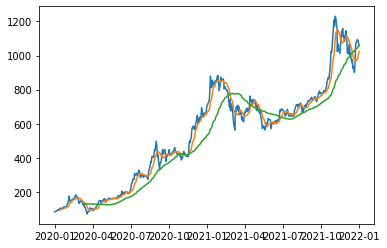

In [68]:
#Visualize Prices and MAs
plt.plot(price.Close)
plt.plot(price['Fast MA'])
plt.plot(price['Slow MA'])

plt.show()

In [69]:
# Set Buy Signal
price['Long'] = price['Fast MA'] > price['Slow MA'] # Set Long Signal if Fast MA is higher than Slow MA yesterday
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1) #Get System Return if long signal, Equals to 1 if not long
price['Sys_Bal'] = STARTING_BALANCE*price.Sys_Ret.cumprod()
price.tail()

,Open,Close,Return,Bench_Bal,Bench Peak,Bench DD,Fast MA,Slow MA,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,
2021-12-27,1073.670044,1093.939941,1.018879,18751.072830,21047.936535,-2296.863705,976.867993,1043.335798,False,1.0,15217.515235
2021-12-28,1109.489990,1088.469971,0.981054,18395.821389,21047.936535,-2652.115145,989.073993,1048.244597,False,1.0,15217.515235
2021-12-29,1098.640015,1086.189941,0.988668,18187.355176,21047.936535,-2860.581359,1001.841986,1052.566196,False,1.0,15217.515235
2021-12-30,1061.329956,1070.339966,1.008489,18341.754142,21047.936535,-2706.182393,1011.276984,1056.687595,False,1.0,15217.515235
2021-12-31,1073.439941,1056.780029,0.984480,18057.087995,21047.936535,-2990.848540,1024.262988,1060.507196,False,1.0,15217.515235


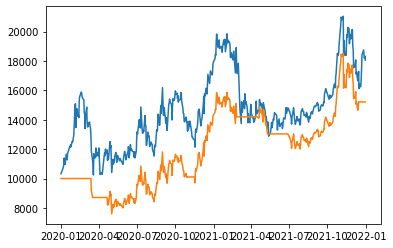

In [70]:
plt.plot(price['Bench_Bal'])
plt.plot(price['Sys_Bal'])
plt.show()

In [71]:
# Compute Returns and Drawdowns of Benchmark and System
sys_return=round(((price.Sys_Bal[-1]/price.Sys_Bal[0])-1)*100,2)
sys_cagr=round((((price.Sys_Bal[-1] / price.Sys_Bal[0]) ** (1/YEARS)-1))*100,2)

bench_return = round(((price['Bench_Bal'][-1] / price['Bench_Bal'][0]) - 1)*100,2)
bench_cagr = round((((price['Bench_Bal'][-1] / price['Bench_Bal'][0]) ** (1/YEARS))-1) * 100, 2)

price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
sys_dd=round((((price.Sys_DD / price.Sys_Peak).min()) * 100),2)

price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
bench_dd=round((((price.Bench_DD / price.Bench_Peak).min()) * 100),2)

In [72]:
# Print Results
print("BACKTEST RESULTS FOR $", stock, ": \n")
print("Observation Period: ", round(YEARS,3), "Years\n")
print(f'Benchmark Total Return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}%')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total Return: {sys_return}%')
print(f'System CAGR: {sys_cagr}%')
print(f'System DD: {sys_dd}%')
print('')
print('Analysis: \n')
print('If you buy only when the Fast Moving Average (', FAST_MA, ") is higher than Slow Moving Average (", SLOW_MA, ") and you sell when it is not, ")
print(f'you get a return of {sys_return}% and a drawdown of {sys_dd}% after {round(YEARS,3)} years.')

BACKTEST RESULTS FOR $ TSLA : 

Observation Period:  2.001 Years

Benchmark Total Return: 74.82%
Benchmark CAGR: 32.19%
Benchmark DD: -35.54%

System Total Return: 52.18%
System CAGR: 23.34%
System DD: -24.25%

Analysis: 

If you buy only when the Fast Moving Average ( 10 ) is higher than Slow Moving Average ( 50 ) and you sell when it is not, 
you get a return of 52.18% and a drawdown of -24.25% after 2.001 years.
